# Решение задачи:

Установка необходимых пакетов:

In [ ]:
!pip install emoji==1.4.1
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.1-py3-none-any.whl size=186377 sha256=2f02f560a10df93fc2797aa8a64b9500742ffe4bc3eba05b66ab3137fef05500
  Stored in directory: /root/.cache/pip/wheels/0d/44/17/320330a9e12226b713b36d3a308259428576bc23ca5ff7d1b3
Successfully built emoji


Импорт библиотек:

In [ ]:
import numpy as np  # Для массивов и случайных чисел
import pandas as pd  # Для DataFrame (удобная обработка данных)
import re  # Регулярные выражения для очистки текста
import string  # Пунктуация для очистки
import emoji  # Удаление эмодзи (опционально)
import warnings  # Подавление предупреждений
import matplotlib.pyplot as plt  # Графики
import seaborn as sns  # Heatmap и визуализации
from datasets import load_dataset  # Загрузка датасета с Hugging Face
from sklearn.model_selection import train_test_split  # Разделение на train/valid
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix  # Метрики
from imblearn.over_sampling import RandomOverSampler  # Балансировка классов
from sklearn import preprocessing  # OneHotEncoder
from transformers import RobertaTokenizerFast, TFRobertaModel  # ruRoberta-large
import tensorflow as tf  # TensorFlow для fine-tuning
from tensorflow import keras  # Keras API

# Воспроизводимость
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Настройка графиков
sns.set_style("whitegrid")
sns.despine()
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Отключение предупреждений
warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

Укажем все классы из датасета:

In [ ]:
all_label_names = ['climate', 'conflicts', 'culture', 'economy', 'gloss', 'health', 'politics', 'science', 'society', 'sports', 'travel']

Определим функцию для матрицы ошибок и функцию для графика распределения классов:

In [ ]:
# Функция для confusion matrix
def conf_matrix(y, y_pred, title, labels):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size": 12})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=12, rotation=45)
    ax.yaxis.set_ticklabels(labels, fontsize=12, rotation=0)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.tight_layout()
    plt.show()

# Функция для графика распределения классов
def plot_class_distribution(df, labels, title):
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x='labels', data=df, palette='mako')
    plt.title(title, fontsize=20)
    ax.set_xticklabels(labels, rotation=45)
    ax.bar_label(ax.containers[0])
    plt.ylabel('Число примеров', fontsize=15)
    plt.xlabel('Класс', fontsize=15)
    plt.show()

Загрузим датасет:

In [ ]:
dataset = load_dataset("data-silence/rus_news_classifier")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/69.1M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/57530 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14383 [00:00<?, ? examples/s]

Определим колонки датасета:

In [ ]:
print("Колонки датасета:")
print(dataset['train'].column_names)  # ['news', 'labels']

Колонки датасета:
['news', 'labels']


Выберем 5 классов и определим их индексы:

In [ ]:
# Фильтрация по 5 классам
selected_classes = {'health': 5, 'science': 7, 'society': 8, 'sports': 9, 'travel': 10}
selected_label_names = ['health', 'science', 'society', 'sports', 'travel']
num_classes = len(selected_label_names)
print(f"Выбранные классы (индексы): {selected_classes}")

Выбранные классы (индексы): {'health': 5, 'science': 7, 'society': 8, 'sports': 9, 'travel': 10}


Этот код определяет функцию `filter_classes`, которая оставляет только примеры из датасета, чьи метки `labels` соответствуют заданным классам в `selected_classes`, а затем применяет эту фильтрацию к датасету, создавая `filtered_dataset`:

In [ ]:
def filter_classes(example):
    return example['labels'] in selected_classes.values()

filtered_dataset = dataset.filter(filter_classes)

Filter:   0%|          | 0/57530 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14383 [00:00<?, ? examples/s]

Этот код конвертирует отфильтрованные данные из датасета `filtered_dataset` в pandas DataFrame, создавая `df_train` из тренировочного набора и `df_test` из тестового набора:

In [ ]:
df_train = pd.DataFrame(filtered_dataset['train'])
df_test = pd.DataFrame(filtered_dataset['test'])

Ознакомимся с более поодробной информацией о датасете и данных в нем:

In [ ]:
print("\nКолонки df_train:")
print(df_train.columns.tolist())

print("\nИнформация о df_train:")
print(df_train.info())
print("\nПервые 5 строк df_train:")
print(df_train.head())

print(f"\nФорма обучающей выборки: {df_train.shape}")
print(f"Форма тестовой выборки: {df_test.shape}")


Колонки df_train:
['news', 'labels']

Информация о df_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23781 entries, 0 to 23780
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    23781 non-null  object
 1   labels  23781 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 371.7+ KB
None

Первые 5 строк df_train:
                                                news  labels
0  В 2021 году Microsoft выпустит специальную вер...       7
1  Британский боксер-тяжеловес Тайсон Фьюри оскор...       9
2  Нидерландская компания U-Boat Worx представила...       7
3  Собор Святого Марка, построенный в IX веке в В...       8
4  Компания Xiaomi до конца осени может начать оф...       7

Форма обучающей выборки: (23781, 2)
Форма тестовой выборки: (5947, 2)


Посмотрим с помощью графика распределение классов до обработки:


Распределение классов в train (до обработки):
labels
5     4931
7     5406
8     4937
9     4791
10    3716
Name: count, dtype: int64


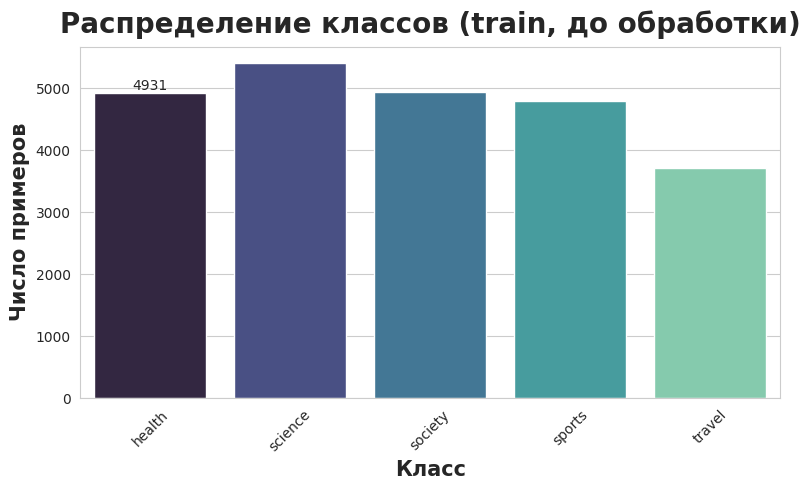

In [ ]:
# Распределение классов
print("\nРаспределение классов в train (до обработки):")
print(df_train['labels'].value_counts().sort_index())
plot_class_distribution(df_train, selected_label_names, "Распределение классов (train, до обработки)")

Удаление дубликатов:

In [ ]:
df_train.drop_duplicates(subset='news', inplace=True)
df_test.drop_duplicates(subset='news', inplace=True)
print(f"\nПосле удаления дубликатов: train={df_train.shape}, test={df_test.shape}")


После удаления дубликатов: train=(23705, 2), test=(5939, 2)


Определим ряд функций для мягкой предобработки данных в датасете:

In [ ]:
# Мягкая предобработка
def strip_emoji(text):
    """Удаляет эмодзи."""
    return re.sub(emoji.get_emoji_regexp(), r"", text)

def strip_links_mentions(text):
    """Удаление ссылок и упоминаний."""
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

def remove_mult_spaces(text):
    """Удаление множественных пробелов."""
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_text(text):
    """Мягкая очистка: эмодзи, ссылки, пробелы; кириллица сохранена."""
    text = strip_emoji(text)
    text = strip_links_mentions(text)
    text = remove_mult_spaces(text)
    return text.lower()

Применение функций к датасетам:

In [ ]:
df_train['text_clean'] = df_train['news'].apply(clean_text)
df_test['text_clean'] = df_test['news'].apply(clean_text)

Пример очистки:

In [ ]:
print("\nПример до/после очистки (первый текст):")
print("Оригинал:", df_train['news'].iloc[0][:200] + "...")
print("Очищенный:", df_train['text_clean'].iloc[0][:200] + "...")


Пример до/после очистки (первый текст):
Оригинал: В 2021 году Microsoft выпустит специальную версию Windows для бюджетных компьютеров. Об этом сообщает издание Windows Latest. Журналисты выяснили, что операционная система для ПК с двумя экранами — Wi...
Очищенный: в 2021 году microsoft выпустит специальную версию windows для бюджетных компьютеров. об этом сообщает издание windows latest. журналисты выяснили, что операционная система для пк с двумя экранами — wi...


Фильтрация коротких текстов (>4 слов) и вывод статистики:

In [ ]:
df_train['text_len'] = df_train['text_clean'].apply(lambda x: len(x.split()))
df_test['text_len'] = df_test['text_clean'].apply(lambda x: len(x.split()))

print("\nСтатистика по длине текстов (train):")
print(df_train['text_len'].describe())


Статистика по длине текстов (train):
count    23705.000000
mean       172.487239
std         67.215416
min         10.000000
25%        130.000000
50%        163.000000
75%        201.000000
max       1292.000000
Name: text_len, dtype: float64


Статистика после фильтрации:

In [ ]:
df_train = df_train[df_train['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]
print(f"\nПосле фильтра (>4 слов): train={df_train.shape}, test={df_test.shape}")


После фильтра (>4 слов): train=(23705, 4), test=(5939, 4)


Определим модель и токенизацию:

In [ ]:
model_name = "ai-forever/ruRoberta-large"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

Этот код определяет функцию `get_token_lens`, которая анализирует длину токенов для первых 1000 текстов из данных с использованием заданного токенизатора, сохраняя длины токенов и отмечая аномалии (outliers) длиной более 128 токенов, при этом выводя первые три аномалии, если они есть. Затем функция применяется к очищенным текстовым данным тренировочного набора `df_train['text_clean']`, результат сохраняется в `token_lens_train`, и выводится средняя и максимальная длина токенов для анализа:

In [ ]:
def get_token_lens(data, tokenizer, max_check=1000):  # Проверяем первые 1000 для скорости
    token_lens = []
    outliers = []
    for i, txt in enumerate(data[:max_check]):
        tokens = tokenizer.encode(txt, max_length=512, truncation=True)
        token_lens.append(len(tokens))
        if len(tokens) > 128:  # Мягче, для новостей
            outliers.append((i, txt[:100], len(tokens)))
    if outliers:
        print("Outliers (>128 токенов):", outliers[:3])  # Показать первые 3
    return token_lens

token_lens_train = get_token_lens(df_train['text_clean'], tokenizer)
print(f"\nСредняя длина токенов (train): {np.mean(token_lens_train):.1f}, макс: {max(token_lens_train)}")

Outliers (>128 токенов): [(0, 'в 2021 году microsoft выпустит специальную версию windows для бюджетных компьютеров. об этом сообщае', 351), (1, 'британский боксер-тяжеловес тайсон фьюри оскорбил украинца александра усика. его слова приводит dail', 205), (2, 'нидерландская компания u-boat worx представила частную субмарину super sub, развивающую скорость до ', 285)]

Средняя длина токенов (train): 270.4, макс: 512


График распределения длины токенов:

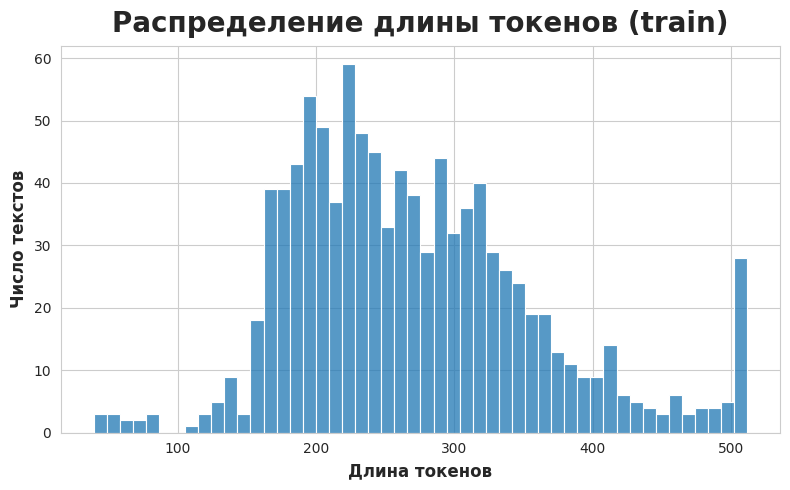

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(token_lens_train, bins=50)
plt.title('Распределение длины токенов (train)', fontsize=20)
plt.xlabel('Длина токенов')
plt.ylabel('Число текстов')
plt.show()

Фильтрация для тестовой и обучающей выборки:

In [ ]:
# Фильтрация outliers (мягко, >256)
df_train = df_train[df_train['text_len'] <= 100]  # По словам, не токенам
df_train = df_train.sample(frac=1, random_state=seed).reset_index(drop=True)
print(f"\nПосле фильтра outliers: train={df_train.shape}")

# Аналогично для test
token_lens_test = get_token_lens(df_test['text_clean'], tokenizer)
df_test = df_test[df_test['text_len'] <= 100]
df_test = df_test.sample(frac=1, random_state=seed).reset_index(drop=True)
print(f"После фильтра outliers: test={df_test.shape}")


После фильтра outliers: train=(1622, 4)
Outliers (>128 токенов): [(0, 'ученые университета неймегена и университета твенте в нидерландах раскрыли, что сложная внутреклеточ', 512), (1, 'стюардесса британских авиалиний лаура рейнольдс (laura reynolds) раскрыла преимущество длительных ре', 349), (2, 'дешевле всего жилье в москве можно снять в молжаниновском районе. его назвали самым доступным для ар', 286)]
После фильтра outliers: test=(424, 4)


Выполним **Oversampling** (балансировка):


Распределение после oversampling:
labels
5     541
7     541
8     541
9     541
10    541
Name: count, dtype: int64


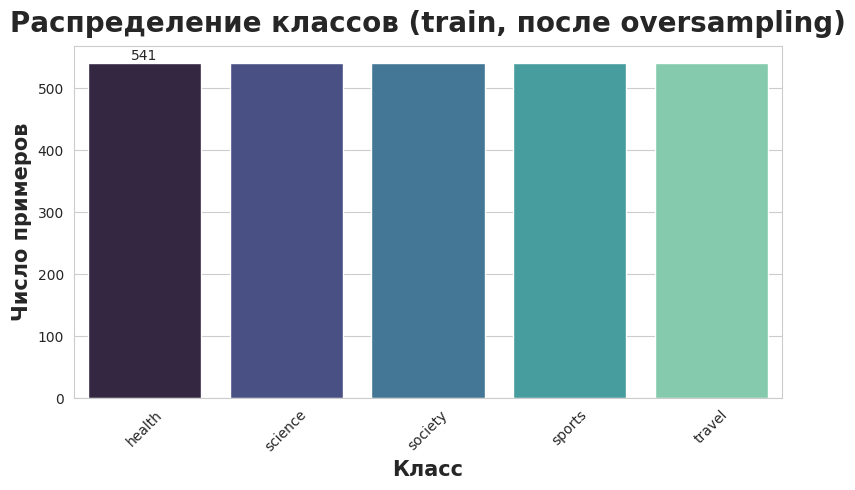

In [ ]:
ros = RandomOverSampler(random_state=seed)
train_x, train_y = ros.fit_resample(df_train[['text_clean']], df_train['labels'])
train_os = pd.DataFrame({'text_clean': train_x['text_clean'], 'labels': train_y.values})

print("\nРаспределение после oversampling:")
print(train_os['labels'].value_counts().sort_index())
plot_class_distribution(train_os, selected_label_names, "Распределение классов (train, после oversampling)")

Выполним ремэппинг меток с проверкой:

In [ ]:
label_map = {5: 0, 7: 1, 8: 2, 9: 3, 10: 4}
train_os['new_label'] = train_os['labels'].map(label_map)
df_train['new_label'] = df_train['labels'].map(label_map)
df_test['new_label'] = df_test['labels'].map(label_map)

# Проверка remapping
print("\nПроверка remapping:")
print("Уникальные 'labels' в train_os:", sorted(train_os['labels'].unique()))
print("Уникальные 'new_label' в train_os:", sorted(train_os['new_label'].unique()))
print("NaN в new_label train_os:", train_os['new_label'].isna().sum())
if train_os['new_label'].isna().sum() > 0:
    print("Внимание: Есть NaN в new_label — проверьте индексы классов!")
    train_os = train_os.dropna(subset=['new_label'])
    print(f"После dropna: {len(train_os)} строк")


Проверка remapping:
Уникальные 'labels' в train_os: [np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
Уникальные 'new_label' в train_os: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
NaN в new_label train_os: 0


Разделение на train/valid:

In [ ]:
X = train_os['text_clean'].values
y = train_os['new_label'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
X_test = df_test['text_clean'].values
y_test = df_test['new_label'].values
print(f"\nTrain/Valid/Test: {len(X_train)}/{len(X_valid)}/{len(X_test)}")

print("Уникальные y_train:", sorted(np.unique(y_train)))
print("Уникальные y_test:", sorted(np.unique(y_test)))


Train/Valid/Test: 2434/271/424
Уникальные y_train: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Уникальные y_test: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


Применим **One-Hot Encoding**:

In [ ]:
ohe = preprocessing.OneHotEncoder(sparse_output=False)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1))
y_valid_ohe = ohe.transform(y_valid.reshape(-1, 1))
y_test_ohe = ohe.transform(y_test.reshape(-1, 1))

Этот код загружает предобученную модель `TFRobertaModel` с названием `model_name`, конвертируя её из PyTorch формата в TensorFlow с помощью `from_pt=True`, и определяет функцию `tokenize`, которая преобразует входные тексты в списки идентификаторов токенов (`input_ids`) и масок внимания (`attention_masks`) с использованием токенизатора, применяя максимальную длину 128, паддинг и усечение. Затем функция применяется к тренировочным (`X_train`), валидационным (`X_valid`) и тестовым (`X_test`) наборам данных, создавая соответствующие пары массивов `input_ids` и `attention_masks` для последующего использования в модели:

In [ ]:
roberta_model = TFRobertaModel.from_pretrained(model_name, from_pt=True)

def tokenize(data, max_len=128):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize(X_train, max_len=128)
valid_input_ids, valid_attention_masks = tokenize(X_valid, max_len=128)
test_input_ids, test_attention_masks = tokenize(X_test, max_len=128)

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized 

Создадим функцию по созданию модели, в которой опишем ее архитектуру. Также выведем подробную статистику о созданной модели:

In [ ]:
def create_model(roberta_model, max_len=128):
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5, decay=1e-6)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    output = roberta_model([input_ids, attention_masks])[1]
    output = tf.keras.layers.Dropout(0.1)(output)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(output)
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(opt, loss=loss, metrics=[accuracy])
    return model

model = create_model(roberta_model, max_len=128)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   3553597   ['input_1[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   44         'input_2[0][0]']             
                             hidden_state=(None, 128, 1                                           
                             024),                                                            

Выполним обучение модели:

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks], y_train_ohe,
    validation_data=([valid_input_ids, valid_attention_masks], y_valid_ohe),
    epochs=4,
    batch_size=16,
)

Epoch 1/4
153/153 [==============================] - 241s 1s/step - loss: 0.4692 - categorical_accuracy: 0.8246 - val_loss: 0.0854 - val_categorical_accuracy: 0.9779
Epoch 2/4
153/153 [==============================] - 210s 1s/step - loss: 0.0589 - categorical_accuracy: 0.9848 - val_loss: 0.0288 - val_categorical_accuracy: 0.9926
Epoch 3/4
153/153 [==============================] - 207s 1s/step - loss: 0.0330 - categorical_accuracy: 0.9910 - val_loss: 0.0499 - val_categorical_accuracy: 0.9926
Epoch 4/4
153/153 [==============================] - 210s 1s/step - loss: 0.0159 - categorical_accuracy: 0.9959 - val_loss: 0.0632 - val_categorical_accuracy: 0.9889


График обучения:

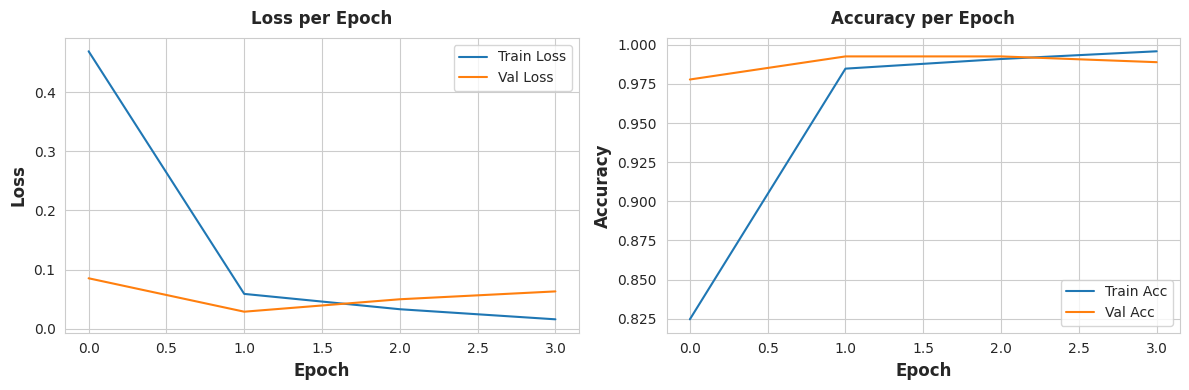

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Выполним предсказания и выведем метрики:

In [ ]:
# Предсказания
result = model.predict([test_input_ids, test_attention_masks])
y_pred = np.argmax(result, axis=1)

# Метрики
print('\nРасчет метрик для ruRoberta-large:')
print(classification_report(y_test, y_pred, target_names=selected_label_names))

14/14 [==============================] - 17s 806ms/step

Расчет метрик для ruRoberta-large:
              precision    recall  f1-score   support

      health       0.95      0.88      0.91        24
     science       0.95      0.97      0.96        90
     society       0.88      0.88      0.88        75
      sports       0.98      1.00      0.99       153
      travel       0.97      0.94      0.96        82

    accuracy                           0.95       424
   macro avg       0.95      0.93      0.94       424
weighted avg       0.95      0.95      0.95       424



Воспользуемся функцией создания матрицы ошибок:

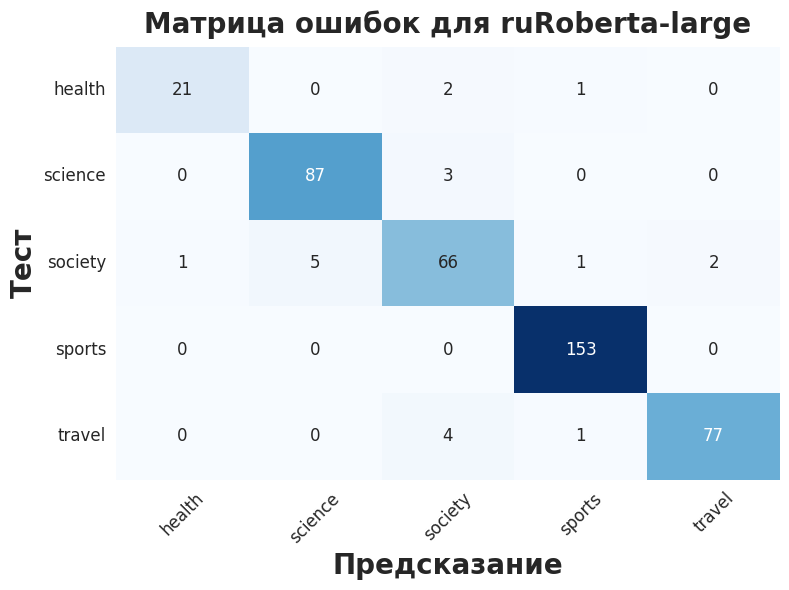

In [ ]:
conf_matrix(y_test, y_pred, 'Матрица ошибок для ruRoberta-large', selected_label_names)

Выведем 5 примеров предсказаний:

In [ ]:
print("\n5 примеров предсказаний на тестовой выборке:")
for i in range(min(5, len(X_test))):
    orig_text = df_test['news'].iloc[i]
    clean_text = X_test[i]
    true_label = selected_label_names[y_test[i]]
    pred_label = selected_label_names[y_pred[i]]
    confidence = np.max(result[i])
    print(f"Пример {i+1}:")
    print(f"Оригинальный текст: {orig_text[:200]}...")
    print(f"Очищенный текст: {clean_text[:200]}...")
    print(f"Истинный класс: {true_label}")
    print(f"Предсказанный класс: {pred_label} (уверенность: {confidence:.2f})")
    print(f"Вероятности: {dict(zip(selected_label_names, result[i]))}")
    print("---")


5 примеров предсказаний на тестовой выборке:
Пример 1:
Оригинальный текст: В сети появилось видео лучших моментов турнира Абсолютного бойцовского чемпионата (UFC) в Лас-Вегасе. Ролик представлен на YouTube-канале UFC Russia. В главном поединке ивента Фрэнсис Нганну лишил тит...
Очищенный текст: в сети появилось видео лучших моментов турнира абсолютного бойцовского чемпионата (ufc) в лас-вегасе. ролик представлен на youtube-канале ufc russia. в главном поединке ивента фрэнсис нганну лишил тит...
Истинный класс: sports
Предсказанный класс: sports (уверенность: 1.00)
Вероятности: {'health': np.float32(8.692587e-06), 'science': np.float32(2.3682258e-05), 'society': np.float32(4.143973e-05), 'sports': np.float32(0.9999199), 'travel': np.float32(6.1920123e-06)}
---
Пример 2:
Оригинальный текст: Россиянка Мирра Андреева разгромила туниску Онс Жабер и вышла в третий круг Australian Open. Об этом сообщает корреспондент «Ленты.ру».Встреча завершилась в двух сетах со счетом 6:0, 6:2. Спортсменки